# Import Packages

In [66]:
import os
from glob import glob
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
from tqdm import tqdm
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import f1_score
import torch.nn.functional as F

# Dataset
## define dataset

In [67]:
class ImageDataset(Dataset):
    def __init__(self, data_dir, transform=None, train=True):
        self.data_dir = data_dir
        self.transform = transform
        self.train = train
        self.data_list = os.listdir(self.data_dir)
        self.channel = 1259
        self.data_indices = [
            (data_index, channel_index)
            for data_index in range(len(self.data_list))
            for channel_index in range(self.channel)
        ]

    def __len__(self):
        return len(self.data_indices)

    def __getitem__(self, index):
        data_index, channel_index = self.data_indices[index]
        data_path = os.path.join(self.data_dir, self.data_list[data_index])
        cube = np.load(glob(os.path.join(data_path, 'seismicCubes_RFC_fullstack*'))[0])
        maskcube = np.load(glob(os.path.join(data_path, 'fault_segments*'))[0])
        image = cube[:, :, channel_index]
        mask = maskcube[:, :, channel_index]
        if self.transform:
            image = self.transform(image).float()
            mask = self.transform(mask).float()
        return image, mask

class CubeDataset(Dataset):
    def __init__(self, data_dir, transform=None, train=True):
        self.data_dir = data_dir
        self.transform = transform
        self.train = train
        self.data_list = os.listdir(self.data_dir)

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, index):
        data_path = os.path.join(self.data_dir, self.data_list[index])
        cube = np.load(glob(os.path.join(data_path, 'seismicCubes_RFC_fullstack*'))[0])
        if self.transform:
            cube = self.transform(cube).astype(np.float32)
        return cube

## initialize dataset

Image shape torch.Size([1, 320, 320])


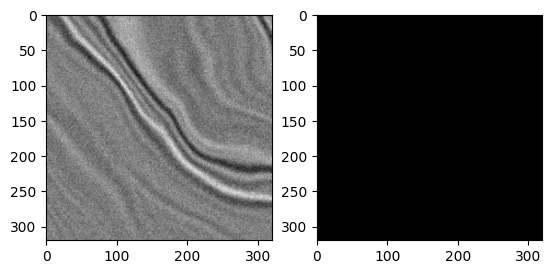

Training set: 1008 images
Validation set: 251 images
Test set: 1 cubes


In [68]:
train_dataset_dir = "data"
test_dataset_dir = "data"
train_transform = transforms.Compose([transforms.ToTensor(),
                                      transforms.Resize((320, 320))
                                      ])
test_transform = transforms.Compose([transforms.ToTensor(),
                                     transforms.Resize((320, 320))])
full_train_dataset = ImageDataset(train_dataset_dir,train_transform, train=True)
test_dataset = CubeDataset(test_dataset_dir, test_transform, train=False)
train_dataset, val_dataset = random_split(full_train_dataset, [0.8, 0.2])

image, mask = train_dataset[200]
print('Image shape',image.shape)
plt.subplot(1, 2, 1)
plt.imshow(image[0], cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(mask[0], cmap='gray')
plt.show()

print('Training set:', len(train_dataset),'images')
print('Validation set:', len(val_dataset),'images')
print('Test set:', len(test_dataset),'cubes')

## initialize dataloader

In [69]:
batch_size = 16
class_num = 2
train_loader = DataLoader(train_dataset, batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Functions
## loss function

In [95]:
class CombinedLoss(nn.Module):
    def __init__(self, smooth=1, alpha=0.8):
        super(CombinedLoss, self).__init__()
        self.smooth = smooth
        self.alpha = alpha
        self.cross_entropy = nn.CrossEntropyLoss()

    def forward(self, preds, targets):
        if targets.dim() == 4:
            targets = targets.squeeze(1)

        if targets.dtype != torch.long:
            targets = targets.long()

        ce_loss = self.cross_entropy(preds, targets)

        preds = torch.softmax(preds, dim=1)
        num_classes = preds.size(1)
        batch_size, height, width = targets.size()
        targets_one_hot = torch.zeros(batch_size, num_classes, height, width, device=preds.device)
        targets_one_hot.scatter_(1, targets.unsqueeze(1), 1)

        intersection = (preds * targets_one_hot).sum(dim=(2, 3))
        union = preds.sum(dim=(2, 3)) + targets_one_hot.sum(dim=(2, 3))
        dice_score = (2. * intersection + self.smooth) / (union + self.smooth)
        dice_loss = 1 - dice_score.mean(dim=1)
        dice_loss = dice_loss.mean()

        combined_loss = self.alpha * dice_loss + (1 - self.alpha) * ce_loss
        return combined_loss

## evaluation functions

In [71]:
def calculate_f1(pred, target, num_classes):
    pred_flat = pred.view(-1).cpu().numpy()
    target_flat = target.view(-1).cpu().numpy()
    # print('t',np.unique(target_flat))
    # print('p',np.unique(pred_flat))
    return f1_score(target_flat, pred_flat, average='macro')


def calculate_miou(pred, target, num_classes):
    ious = []
    pred = torch.argmax(pred, dim=1)
    for cls in range(num_classes):
        pred_inds = pred == cls
        target_inds = target == cls
        intersection = torch.sum(pred_inds & target_inds).item()
        union = torch.sum(pred_inds | target_inds).item()
        if union == 0:
            ious.append(float('nan'))
        else:
            ious.append(intersection / union)
    return np.nanmean(ious)

# Model
## set device


In [72]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device : {device}')

Device : cpu


## load model

In [73]:
from segmentation_models_pytorch import Unet
model = Unet(
    encoder_name="tu-hrnet_w32",
    encoder_weights="imagenet",
    in_channels=1,
    classes=2
)

## model information

In [74]:
import torch

image, mask = train_dataset[200]
print('Image shape',image.shape)
print('Mask shape',mask.shape)
image = image.float()
mask = mask.float()
image = image.unsqueeze(0)
pred = model(image)
print(pred.shape)

Image shape torch.Size([1, 320, 320])
Mask shape torch.Size([1, 320, 320])
torch.Size([1, 2, 320, 320])


# Training
## initialize parameters

In [96]:
EPOCHS = 10
LR = 1e-5

criterion = CombinedLoss()
params = model.parameters()
optimizer = torch.optim.AdamW(params, lr=LR)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)
model_path = "model"

train_losses = []
train_mious = []
val_F1s = []
val_mious = []

## start training

In [97]:
for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    running_miou = 0.0

    train_loader_tqdm = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{EPOCHS}", unit="batch")

    for images, targets in train_loader_tqdm:
        images = images.to(device)
        targets = targets.to(device)
        # print(np.unique(targets))

        optimizer.zero_grad()
        outputs = model(images)
        soft_pro = F.softmax(outputs, dim=1)
        # loss = criterion(outputs, targets.long())
        loss = criterion(soft_pro, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        running_miou += calculate_miou(outputs, targets, class_num)

        train_loader_tqdm.set_postfix(
            {"Loss": f"{loss:.4f}", "MIOU": f"{(running_miou / (train_loader_tqdm.n + 1)):.4f}"})

    epoch_loss = running_loss / len(train_loader)
    epoch_miou = running_miou / len(train_loader)
    train_losses.append(epoch_loss)
    train_mious.append(epoch_miou)
    print(f'Training Loss: {epoch_loss:.4f}, MIOU: {epoch_miou:.4f}')

    model.eval()
    val_running_miou = 0.0
    val_running_f1 = 0.0
    val_loader_tqdm = tqdm(val_loader, desc=f"Epoch {epoch + 1}/{EPOCHS}", unit="batch")
    with torch.no_grad():
        for val_images, val_targets in val_loader_tqdm:
            val_images = val_images.to(device)
            val_targets = val_targets.to(device)

            val_outputs = model(val_images)
            val_preds = torch.argmax(val_outputs, dim=1)
            val_running_miou += calculate_miou(val_outputs, val_targets, class_num)
            val_running_f1 += calculate_f1(val_preds, val_targets, class_num)
            # print(val_preds.shape, val_targets.shape)
            val_loader_tqdm.set_postfix(
                {"MIOU": f"{(val_running_miou / (val_loader_tqdm.n + 1)):.4f}",
                 "F1": f"{(val_running_f1 / (val_loader_tqdm.n + 1)):.4f}"})

    val_epoch_miou = val_running_miou / len(val_loader)
    val_epoch_f1 = val_running_f1 / len(val_loader)
    val_mious.append(val_epoch_miou)
    val_F1s.append(val_epoch_f1)
    print(
        f'Validation MIOU: {val_epoch_miou:.4f},F1-score: {val_epoch_f1:.4f}')

    torch.save(model.state_dict(), f'{model_path}/epoch{epoch}.pth')
    print('model saved')

Epoch 1/10:   2%|▏         | 1/63 [00:26<27:38, 26.75s/batch, Loss=0.7998, MIOU=0.0822]


KeyboardInterrupt: 

# Result

In [ ]:
plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plt.plot(train_losses)
plt.title('Training Loss')
plt.subplot(2, 2, 2)
plt.plot(train_mious)
plt.title('Training MIOU')
plt.subplot(2, 2, 3)
plt.plot(val_mious)
plt.title('Validation MIOU')
plt.subplot(2, 2, 4)
plt.plot(val_F1s)
plt.title('Validation F1')
plt.show()

# Testing